In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
import pandas as pd
import statistics
import time
from tqdm import tqdm
%matplotlib inline

                                             Property Annotation        Value
0                               Porosity in fraction:        phi     0.500000
1                             Reservoir Length in ft:          L  1000.000000
2                             Reservoir Height in ft:          H    10.000000
3                                    Viscosity in cp:         mu     0.800000
4                    Total Compressibility in psi^-1:         Ct     0.000005
5            Fluid Formation Volume Factor in rb/stb:         Bo     1.100000
6                                  Time Step in days:      Del_t     0.003000
7                               Number of Time Steps:         Nt   500.000000
8                Number of Blocks in both directions:          N    17.000000
9                   Reservoir Pressure in psi at t=0:         Pi  2000.000000
10  Surface flow rate at center of reservoir in st...        qsc   100.000000
11                                 Permeability in md          k

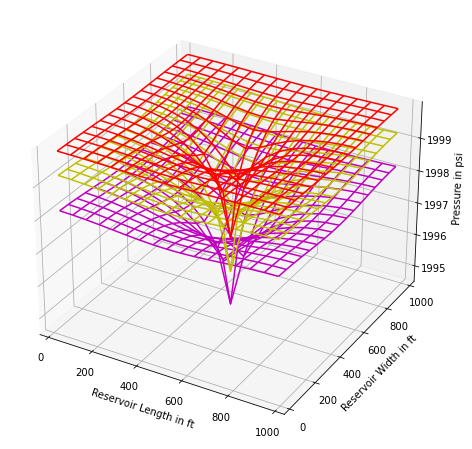

In [2]:
xls = pd.ExcelFile('Data_2D_1.xlsx')
Reservoir_data = pd.read_excel(xls, 'Sheet1')
print(Reservoir_data)
print("\n")
phi=np.float64(Reservoir_data['Value'][0])
L=np.float64(Reservoir_data['Value'][1])
W=np.float64(Reservoir_data['Value'][1])
H=np.float64(Reservoir_data['Value'][2])
mu=np.float64(Reservoir_data['Value'][3])
Ct=np.float64(Reservoir_data['Value'][4])
Bo=np.float64(Reservoir_data['Value'][5])
Del_t=np.float64(Reservoir_data['Value'][6])
Nt=int(Reservoir_data['Value'][7])
N=int(Reservoir_data['Value'][8])
Del_x=L/N
print("\nSize of Block: ", Del_x, "ft")
Pi=float(Reservoir_data['Value'][9])
qsc=float(Reservoir_data['Value'][10])
k=float(Reservoir_data['Value'][11])
print("\nIC \n at t=0, Reservoir Pressure is ", Pi, " psi \nBCs \n Surface production rate at the centre block, i.e. (",(N+1)/2,",",(N+1)/2,") is ", qsc, "stb/day \n at the reservoir boundaries (NEUMANN BC), NO  FLOW is there i.e., (Del_P/Del_x)=0\n")
Psc=5.615*Bo*Del_t*qsc/W/H/Del_x/phi/Ct
eta=0.00633*k*Del_t/phi/mu/Ct/(Del_x**2)
print(eta)
print("\n")
print("Checking for Stability Criteria of eta < 0.5 for Explicit Method:")
if eta<0.5:
    print("Satisfied!")
else:
    print("Stability criteria not met \n Input NEW VALUES for Time Step and Number of Blocks")
P=np.full((Nt+1,N,N),Pi,dtype=np.float64)
for l in range(1,Nt+1):
    for i in range(0,N):
        for j in range(0,N):
            if i==0 and j==0:
                P[l,i,j]=(1-2*eta)*P[l-1,i,j]+eta*P[l-1,i,j+1]+eta*P[l-1,i+1,j]
            elif i==0 and j==N-1:
                P[l,i,j]=(1-2*eta)*P[l-1,i,j]+eta*P[l-1,i,j-1]+eta*P[l-1,i+1,j]
            elif i==N-1 and j==0:
                P[l,i,j]=(1-2*eta)*P[l-1,i,j]+eta*P[l-1,i,j+1]+eta*P[l-1,i-1,j]
            elif i==N-1 and j==N-1:
                P[l,i,j]=(1-2*eta)*P[l-1,i,j]+eta*P[l-1,i,j-1]+eta*P[l-1,i-1,j]
            elif i!=0 and i!=N-1 and j==0:
                P[l,i,j]=(1-3*eta)*P[l-1,i,j]+eta*P[l-1,i,j+1]+eta*P[l-1,i-1,j]+eta*P[l-1,i+1,j]
            elif i!=0 and i!=N-1 and j==N-1:
                P[l,i,j]=(1-3*eta)*P[l-1,i,j]+eta*P[l-1,i,j-1]+eta*P[l-1,i-1,j]+eta*P[l-1,i+1,j]
            elif i==N-1 and j!=0 and j!=N-1:
                P[l,i,j]=(1-3*eta)*P[l-1,i,j-1]+eta*P[l-1,i,j-1]+eta*P[l-1,i,j+1]+eta*P[l-1,i-1,j]
            elif i==0 and j!=0 and j!=N-1:
                P[l,i,j]=(1-3*eta)*P[l-1,i,j]+eta*P[l-1,i,j-1]+eta*P[l-1,i,j+1]+eta*P[l-1,i+1,j]
            elif i==(N-1)/2 and j==(N-1)/2:
                P[l,i,j]=-Psc+eta*P[l-1,i,j-1]+eta*P[l-1,i,j+1]+(1-4*eta)*P[l-1,i,j]+eta*P[l-1,i-1,j]+eta*P[l-1,i+1,j]
            else:
                P[l,i,j]=eta*P[l-1,i,j-1]+eta*P[l-1,i,j+1]+(1-4*eta)*P[l-1,i,j]+eta*P[l-1,i-1,j]+eta*P[l-1,i+1,j]
print("\n")
m=[]
for i in range(N):
    m.append((i+0.5)*Del_x)
plt.figure(figsize=(8,8))
k=plt.axes(projection='3d')
X, Y = np.meshgrid(m, m)
k.plot_wireframe(X, Y,P[math.floor(Nt/10),:,:],color='r')
k.plot_wireframe(X, Y,P[math.floor(Nt/2),:,:],color='y')
k.plot_wireframe(X, Y,P[10*math.floor(Nt/10),:,:],color='m')
k.set_xlabel('Reservoir Length in ft')
k.set_ylabel('Reservoir Width in ft')
k.set_zlabel('Pressure in psi')
print('Red => Time Step= '+str(math.floor(Nt/10)))
print('Yellow => Time Step= '+str(math.floor(Nt/2)))
print('Magenta => Time Step= '+str(10*math.floor(Nt/10)))
plt.grid()
plt.show()

In [4]:
# Dynamic Heatmap of the pressure simulation with 20 iterations
%matplotlib qt
Pn=np.full(((Nt//25),N,N),0,dtype=np.float64)
for l in range(0,(Nt//25)):
    for i in range(0,N):
        for j in range(0,N):
            if l==0:
                Pn[l,i,j]=P[1,i,j]
            elif l==1:
                Pn[l,i,j]=P[5*l,i,j]
            else:
                Pn[l,i,j]=P[10*(l-1),i,j]
fig=plt.figure(figsize=(8,8))
plt.style.use('default')
for i in tqdm(range(0,(Nt//25))):
    time.sleep(1)
    plt.imshow(Pn[i])
    fig.canvas.draw()
    fig.canvas.flush_events()

100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


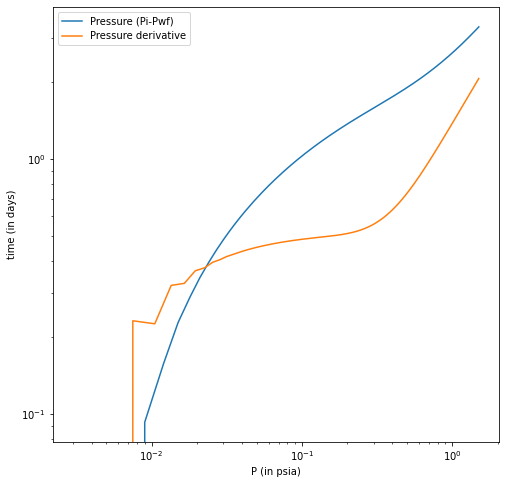

In [3]:
# pressure diagnostic plot with del_p and Pressure derivative
%matplotlib inline
plt.figure(figsize=(8,8))
plt.loglog(np.arange(1,Nt+1)*Del_t, Pi-P[1:,int(0.5*N+0.5),int(0.5*N+0.5)],label='Pressure (Pi-Pwf)')
Pw=Pi-P[1:,int(0.5*N+0.5),int(0.5*N+0.5)]
t=np.arange(1,Nt+1)*Del_t
Pd=np.zeros((Nt-1))
td=np.zeros((Nt-1))
for i in range(Nt-1):
    td[i]=((t[i+1]+t[i])/2)
    Pd[i]=((t[i+1]+t[i])/2)*(Pw[i+1]-Pw[i])/(t[i+1]-t[i])
plt.loglog(td,Pd,label='Pressure derivative')
plt.xlabel("P (in psia)")
plt.ylabel("time (in days)")
plt.legend()

# plot of derivative shows slope as 1 at LTR which is characteristic of semi-steady state (bounded reservoir). Also, note that ETR of derivative has no hump, since our model has no skin and wellbore storage effects.

10000